In [1]:
import sys 
from extraction.extract import *
import math
import numpy
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from datetime import datetime
from scipy.stats import norm
sys.path.append(".")

# GENERAL

An LSTM model that trains on a time period of data in order to make a prediction at a predetermined time interval in the future is coded. Because LSTMs are designed to have a loockback interval where they look into the past to make a prediction in the future, a lot of data preparation must be done to be able to feed it to the model, as will be explained below.

## DATA PREPARATION

The dataset used for the LSTM model was generated with the external "GenerateNNdata". In order to make it compatible with the LSTM workframe the dataset had to be modified such that a certain number of past timesteps are used in order to predict a certain time in the future. The structure of the final version of the dataset is given by the "series_to_supervised" function, which takes care of only including data corresponding to the aforementioned timesteps. Moreover, the unnecessary columns ('departuresArrivalDelay' and 'arrivalsDepartureDelay') are dropped and the remaining ones are reordered such that the target features ('departuresDepartureDelay' and 'arrivalsArrivalDelay') are placed at the end. The data is also scaled and then further processed in order to drop the columns corresponding to future steps which we do not want to predict.

In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# Generate single airport data and move target labels to the last 2 columns 
dataset = generateNNdata("EGLL", timeslotLength=15, catagoricalFlightDuration=False, start=datetime(2018, 3, 1), end=datetime(2018, 3, 31), forceRegenerateData=True)
display(dataset)
dataset = dataset.set_index("timeslot")
dataset.drop(columns=['departuresArrivalDelay','arrivalsDepartureDelay'])
label1 = dataset.pop('departuresDepartureDelay')
dataset.insert(len(dataset.columns), 'departuresDepartureDelay', label1)
label2 = dataset.pop('arrivalsArrivalDelay')
dataset.insert(len(dataset.columns), 'arrivalsArrivalDelay', label2)
# display(dataset)
test_dataset = generateNNdata("EGLL", timeslotLength=15, catagoricalFlightDuration=False, start=datetime(2018, 6, 1), end=datetime(2018, 6, 30), forceRegenerateData=True)
test_dataset = test_dataset.set_index("timeslot")
test_dataset.drop(columns=['departuresArrivalDelay','arrivalsDepartureDelay'])
label1 = test_dataset.pop('departuresDepartureDelay')
test_dataset.insert(len(test_dataset.columns), 'departuresDepartureDelay', label1)
label2 = test_dataset.pop('arrivalsArrivalDelay')
test_dataset.insert(len(test_dataset.columns), 'arrivalsArrivalDelay', label2)

display(dataset)

# Normalize values
values = dataset.values
test_values = test_dataset.values


# Ensure all data is float
values = values.astype('float32')
test_values = test_values.astype('float32')


# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
test_scaled = scaler.fit_transform(test_values)
# display(scaled)


# Frame as supervised learning
number_of_past_steps = 12
number_of_future_steps = 12
# number_of_future_steps2 = 6
number_of_outputs = 2
reframed = series_to_supervised(scaled, n_in=number_of_past_steps, n_out=number_of_future_steps)
test_reframed = series_to_supervised(test_scaled, n_in=number_of_past_steps, n_out=number_of_future_steps)


# Create a list of column names to drop
column_drop_lst = []
for timestep in range(number_of_future_steps):
    for variable in range(1, len(dataset.columns) + 1):
        if timestep == 0:
            if variable > len(dataset.columns) - number_of_outputs:
                column_drop_lst.append(f"var{variable}(t)")
        elif timestep == number_of_future_steps-1 and variable > len(dataset.columns) - number_of_outputs:
            pass
        else:
            column_drop_lst.append(f"var{variable}(t+{timestep})")

# column_drop_lst.remove(f'var19(t+{number_of_future_steps2-1})')
# column_drop_lst.remove(f'var20(t+{number_of_future_steps2-1})')


# Drop columns we don't want to predict
reframed.drop(columns=reframed[column_drop_lst], inplace=True)
test_reframed.drop(columns=test_reframed[column_drop_lst], inplace=True)
display(reframed)
# display(test_reframed)


# Remove rows that contain variables of night
for timestep in range(1, number_of_past_steps):
    reframed = reframed.query(f'`var1(t-{timestep})` != 0 | `var2(t-{timestep})` != 0')

for timestep in range(1, number_of_past_steps):
    no_night_reframed = test_reframed.query(f'`var1(t-{timestep})` != 0 | `var2(t-{timestep})` != 0')

display(reframed)

Generating NN data for EGLL with a timeslot length of 15 minutes


,timeslot,departing,arriving,lowcost,arrivalsFlightDuration,arrivalsDepartureDelay,arrivalsArrivalDelay,departuresFlightDuration,departuresDepartureDelay,departuresArrivalDelay,...,capacityFilled,weekend,winter,spring,summer,autumn,night,morning,afternoon,evening
0,2018-03-01 00:00:00,1,0,0.0,0.0,0.0,0.0,402.0,24.0,62.0,...,0.011364,0,0,1,0,0,1,0,0,0
1,2018-03-01 00:15:00,1,0,0.0,0.0,0.0,0.0,388.0,-20.0,-25.0,...,0.011364,0,0,1,0,0,1,0,0,0
2,2018-03-01 00:30:00,1,0,0.0,0.0,0.0,0.0,260.0,-4.0,-7.0,...,0.011364,0,0,1,0,0,1,0,0,0
3,2018-03-01 00:45:00,1,1,0.0,53.0,-4.0,-14.0,249.0,10.0,36.0,...,0.022727,0,0,1,0,0,1,0,0,0
4,2018-03-01 01:00:00,1,0,0.0,0.0,0.0,0.0,408.0,-14.0,-24.0,...,0.011364,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,2018-03-30 22:45:00,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0,0,1,0,0,0,0,0,1
2876,2018-03-30 23:00:00,0,1,0.0,61.0,17.0,28.0,0.0,0.0,0.0,...,0.011364,0,0,1,0,0,0,0,0,1
2877,2018-03-30 23:15:00,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0,0,1,0,0,0,0,0,1
2878,2018-03-30 23:30:00,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0,0,1,0,0,0,0,0,1


Generating NN data for EGLL with a timeslot length of 15 minutes


,departing,arriving,lowcost,arrivalsFlightDuration,arrivalsDepartureDelay,departuresFlightDuration,departuresArrivalDelay,planes,capacityFilled,weekend,winter,spring,summer,autumn,night,morning,afternoon,evening,departuresDepartureDelay,arrivalsArrivalDelay
timeslot,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,1,0,0.0,0.0,0.0,402.0,62.0,-1,0.011364,0,0,1,0,0,1,0,0,0,24.0,0.0
2018-03-01 00:15:00,1,0,0.0,0.0,0.0,388.0,-25.0,-1,0.011364,0,0,1,0,0,1,0,0,0,-20.0,0.0
2018-03-01 00:30:00,1,0,0.0,0.0,0.0,260.0,-7.0,-1,0.011364,0,0,1,0,0,1,0,0,0,-4.0,0.0
2018-03-01 00:45:00,1,1,0.0,53.0,-4.0,249.0,36.0,0,0.022727,0,0,1,0,0,1,0,0,0,10.0,-14.0
2018-03-01 01:00:00,1,0,0.0,0.0,0.0,408.0,-24.0,-1,0.011364,0,0,1,0,0,1,0,0,0,-14.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-30 22:45:00,0,0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0,0,1,0,0,0,0,0,1,0.0,0.0
2018-03-30 23:00:00,0,1,0.0,61.0,17.0,0.0,0.0,1,0.011364,0,0,1,0,0,0,0,0,1,0.0,28.0
2018-03-30 23:15:00,0,0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0,0,1,0,0,0,0,0,1,0.0,0.0


,var1(t-12),var2(t-12),var3(t-12),var4(t-12),var5(t-12),var6(t-12),var7(t-12),var8(t-12),var9(t-12),var10(t-12),...,var11(t),var12(t),var13(t),var14(t),var15(t),var16(t),var17(t),var18(t),var19(t+11),var20(t+11)
12,0.052632,0.00,0.000000,0.000000,0.240000,0.498141,0.896907,0.428571,0.030303,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.269231,0.211765
13,0.052632,0.00,0.000000,0.000000,0.240000,0.480793,0.000000,0.428571,0.030303,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.660256,0.800000
14,0.052632,0.00,0.000000,0.000000,0.240000,0.322181,0.185567,0.428571,0.030303,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.559829,0.211765
15,0.052632,0.05,0.000000,0.064139,0.186667,0.308550,0.628866,0.464286,0.060606,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.533333,0.211765
16,0.052632,0.00,0.000000,0.000000,0.240000,0.505576,0.010309,0.428571,0.030303,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.512821,0.211765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2864,0.789474,0.35,0.242424,0.105630,0.314286,0.205535,0.335395,0.178571,0.666667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.269231,0.211765
2865,0.684211,0.40,0.253968,0.325534,0.368333,0.270422,0.325932,0.285714,0.636364,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.269231,0.541176
2866,0.473684,0.30,0.000000,0.248084,0.275556,0.171692,0.320733,0.357143,0.454545,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.269231,0.211765
2867,0.315789,0.45,0.177778,0.203442,0.361481,0.134862,0.283505,0.571429,0.454545,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.269231,0.211765


,var1(t-12),var2(t-12),var3(t-12),var4(t-12),var5(t-12),var6(t-12),var7(t-12),var8(t-12),var9(t-12),var10(t-12),...,var11(t),var12(t),var13(t),var14(t),var15(t),var16(t),var17(t),var18(t),var19(t+11),var20(t+11)
35,0.000000,0.00,0.000000,0.000000,0.240000,0.000000,0.257732,0.464286,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.562500,0.550980
36,0.105263,0.05,0.000000,0.256555,0.746667,0.161710,0.613402,0.428571,0.090909,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.615385,0.633484
37,0.157895,0.00,0.000000,0.000000,0.240000,0.105741,0.570447,0.357143,0.090909,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.477564,0.662353
38,0.263158,0.00,0.000000,0.000000,0.240000,0.132342,0.470103,0.285714,0.151515,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.381410,0.680000
39,0.315789,0.00,0.000000,0.000000,0.240000,0.085295,0.537801,0.250000,0.181818,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.545455,0.677941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2864,0.789474,0.35,0.242424,0.105630,0.314286,0.205535,0.335395,0.178571,0.666667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.269231,0.211765
2865,0.684211,0.40,0.253968,0.325534,0.368333,0.270422,0.325932,0.285714,0.636364,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.269231,0.541176
2866,0.473684,0.30,0.000000,0.248084,0.275556,0.171692,0.320733,0.357143,0.454545,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.269231,0.211765
2867,0.315789,0.45,0.177778,0.203442,0.361481,0.134862,0.283505,0.571429,0.454545,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.269231,0.211765


## DATA EXPLORATION

The cell below is used to explore the distribution of the output variables by plotting their normal distributions and also their correspinding histograms (for visualisation purposes). This will give us an indication for the accuracy of our model and whether the obtained performance metrics make sense in relation to the data distribution.

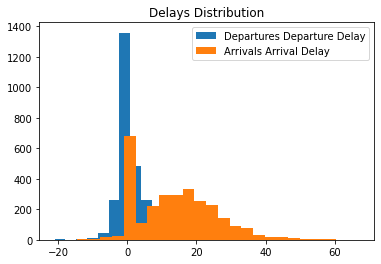

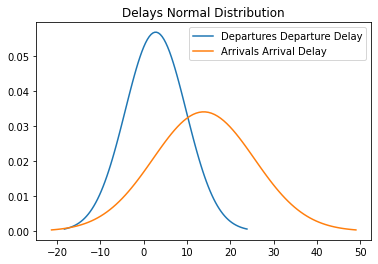

Deprartures Departure Delay mean: 2.78
Arrivals Arrival Delay mean: 13.86
Deprartures Departure Delay standard deviation: 7.02
Arrivals Arrival Delay standard deviation: 11.71


In [3]:
depdel = dataset["departuresDepartureDelay"].to_numpy()
arrdel = dataset["arrivalsArrivalDelay"].to_numpy()

mean_depdel= numpy.mean(depdel)
std_depdel = numpy.std(depdel)
mean_arrdel = numpy.mean(arrdel)
std_arrdel = numpy.std(arrdel)

x_depdel = numpy.linspace(mean_depdel - 3*std_depdel, mean_depdel + 3*std_depdel, 100)
x_arrdel = numpy.linspace(mean_arrdel - 3*std_arrdel, mean_arrdel + 3*std_arrdel, 100)

normal_depdel = norm.pdf(x_depdel, mean_depdel, std_depdel)
normal_arrdel = norm.pdf(x_arrdel, mean_arrdel, std_arrdel)

plt.figure(1)
bin_num = 25
plt.title('Delays Distribution')
plt.hist(depdel, bins=bin_num, label='Departures Departure Delay')
plt.hist(arrdel, bins=bin_num, label='Arrivals Arrival Delay')
plt.legend()

plt.figure(2)
plt.title("Delays Normal Distribution")
plt.plot(x_depdel, normal_depdel, label='Departures Departure Delay')
plt.plot(x_arrdel, normal_arrdel, label='Arrivals Arrival Delay')
plt.legend()

plt.show()

print("Deprartures Departure Delay mean:", round(mean_depdel, 2))
print("Arrivals Arrival Delay mean:", round(mean_arrdel, 2))
print("Deprartures Departure Delay standard deviation:", round(std_depdel, 2))
print("Arrivals Arrival Delay standard deviation:", round(std_arrdel, 2))

## DEFINE AND FIT INITIAL MODEL

What can be seen below is the splitting of the data into the training and the test sets. Out of the one month worth of data, 600 hours are used for training and the rest are used for testing. After reshaping the sets into the desired form for the proper functioning of the LSTM, the data is fitted on a single-layer LSTM model. After iterating multiple times for different numbers of epochs, we decided that 50 epochs are enough, since the errors did not change significantly after this value.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 200)            367200    
_________________________________________________________________
dropout (Dropout)            (None, 1, 200)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 400)            961600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 400)            0         
_________________________________________________________________
dense (Dense)                (None, 1, 50)             20050     
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 800)            2723200   
_________________________________________________________________
dense_1 (Dense)              (None, 1, 50)             4

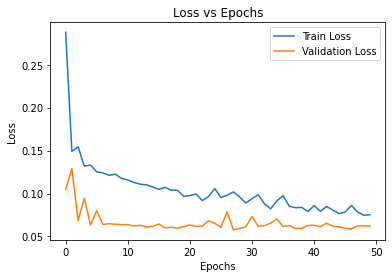

In [4]:
values = reframed.values
test_values = test_reframed.values
no_night_values = no_night_reframed.values
val_ratio = 0.3
train_index = int(val_ratio * len(reframed))


# Split into train and test sets
train = values[:(train_index), :]
val = values[train_index:, :]
test = test_values
no_night = no_night_values

# Split into input and outputs
train_X, train_y = train[:, :-2], train[:, -2:]
val_X, val_y = val[:, :-2], val[:, -2:]
test_X, test_y = test[:, :-2], test[:, -2:]
no_night_X, no_night_y = no_night[:, :-2], no_night[:, -2:]


# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], -1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], -1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], -1, test_X.shape[1]))
no_night_X = no_night_X.reshape((no_night_X.shape[0], -1, no_night_X.shape[1]))

# Design LSTM
model = Sequential()
model.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(400, return_sequences=True))
model.add(Dropout(0.25))
model.add(Dense(50))
model.add(LSTM(800, return_sequences=True))
model.add(Dense(50))
model.add(LSTM(300))
model.add(Dropout(0.25))
model.add(Dense(25))
model.add(Dropout(0.25))
model.add(Dense(10))
model.add(Dropout(0.25))
model.add(Dense(2))
model.compile(loss='mae', optimizer='adam')
model.summary()


# Fit data
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data = (test_X, test_y), verbose=0, shuffle=False)


# Accuracies of seperate month of data
# all_times_accuracy = model.evaluate(test_X, test_y)
# no_night_accuracy = model.evaluate(no_night_X, no_night_y)
# print("Accuracy of all data of June:", round(all_times_accuracy,5))
# print("Accuracy of no night data of June:", round(no_night_accuracy, 5))


# Generate predictions
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))


# Split and reshape the two desired outputs in separate arrays to prepare for inverse scaling
yhat1 = yhat[:, 0]
yhat2 = yhat[:, 1]
yhat1 = yhat1.reshape(len(yhat), 1)
yhat2 = yhat2.reshape(len(yhat), 1)


# Also split the real values of the labels and reshape for inverse scaling
test_y_1 = test_y[:, 0]
test_y_2 = test_y[:, 1]
test_y_1 = test_y_1.reshape(len(test_y), 1)
test_y_2 = test_y_2.reshape(len(test_y), 1)


# Inverse transform the predictions
inv_yhat_1 = concatenate((yhat1, yhat2, test_X[:, 0:18]), axis=1)
inv_yhat_1 = scaler.inverse_transform(inv_yhat_1)
inv_yhat_1 = inv_yhat_1[:, :2]


# Inverse transform the real values of the labels
inv_y_1 = concatenate((test_y_1, test_y_2, test_X[:, 0:18]), axis=1)
inv_y_1 = scaler.inverse_transform(inv_y_1)
inv_y_1 = inv_y_1[:, :2]


# calculate MAE between predicted and actual labels
mae1 = mean_absolute_error(inv_y_1[:, 0], inv_yhat_1[:, 0])
mae2 = mean_absolute_error(inv_y_1[:, 1], inv_yhat_1[:, 1])


print('Test MAE1: %.3f' % mae1)
print('Test MAE2: %.3f' % mae2)


# Plot loss
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
pyplot.plot(history.history['loss'], label='Train Loss')
pyplot.plot(history.history['val_loss'], label='Validation Loss')
pyplot.legend()
pyplot.show()

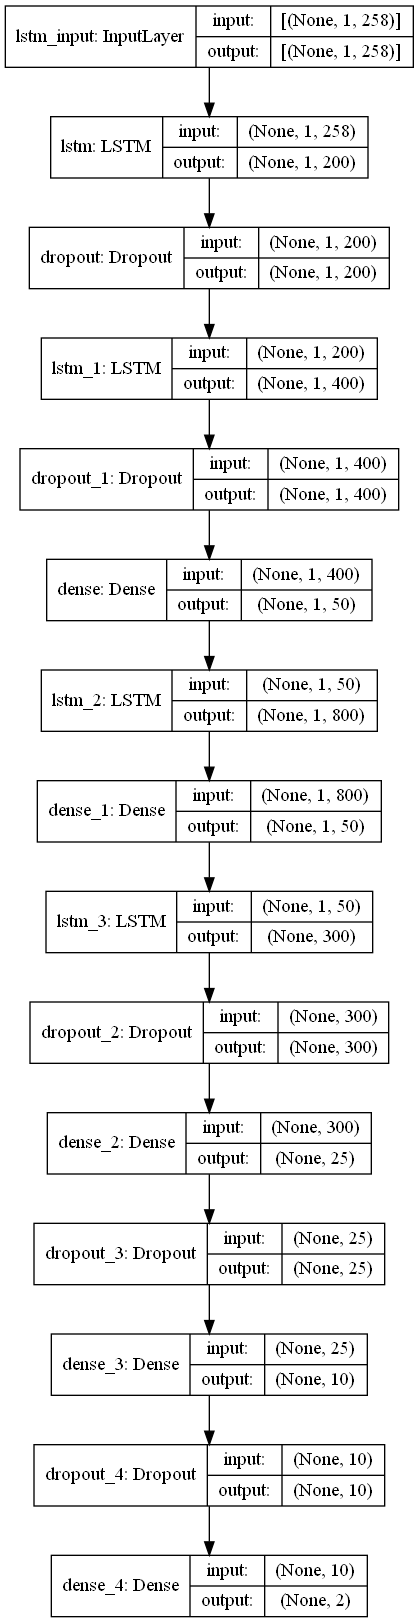

In [7]:
import tensorflow as tf

tf.keras.utils.plot_model(model, to_file='lstm_structure.png', show_shapes=True)

## Parameter Tuning

The next two cells are used for tuning the number of neurons of the LSTM model and the look-back parameter (that is, how much back in time we go for training the LSTM), respectively. The mean absolute errors are plotted against both of these parameters and the minimums are found for each case. In order to keep the running time at an acceptable level, the two tunings are performed separately, in order to offer a general view on the best values of these parameters. It is also observed that the minimum values of the MAE's only vary by a very tiny amount, regardless of the parameters' values. The obtained results are also inverse scaled back to the initial scale for visualising them and for having the MAE's in the desired scale as well.

In [6]:
mae1_lst = []
mae2_lst = []
neurons_lst = numpy.arange(2, 300, 1)

for neurons in neurons_lst:


    # Design the model
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
    model.add(Dropout(0.25))
    model.add(LSTM(2*neurons, return_sequences=True))
    model.add(Dropout(0.25))
    model.add(Dense(50))
    model.add(LSTM(4*neurons, return_sequences=True))
    model.add(Dense(50))
    model.add(LSTM(2*neurons))
    model.add(Dropout(0.25))
    model.add(Dense(25))
    model.add(Dropout(0.25))
    model.add(Dense(10))
    model.add(Dropout(0.25))
    model.add(Dense(2))
    model.compile(loss='mae', optimizer='adam')
    # model.summary()


    # fit network
    history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data = (val_X, val_y), verbose=0, shuffle=False) #validation_data=(val_X, val_y),


    # Generate predictions

    yhat = model.predict(val_X)
    reshaped_val_X = val_X.reshape((val_X.shape[0], val_X.shape[2]))


    # Split and reshape the two desired outputs in separate arrays to prepare for inverse scaling
    yhat1 = yhat[:, 0]
    yhat2 = yhat[:, 1]
    yhat1 = yhat1.reshape(len(yhat), 1)
    yhat2 = yhat2.reshape(len(yhat), 1)


    # Also split the real values of the labels and reshape for inverse scaling
    val_y_1 = val_y[:, 0]
    val_y_2 = val_y[:, 1]
    val_y_1 = val_y_1.reshape(len(val_y), 1)
    val_y_2 = val_y_2.reshape(len(val_y), 1)


    # Inverse transform the predictions
    inv_yhat_1 = concatenate((yhat1, yhat2, reshaped_val_X[:, 0:18]), axis=1)
    inv_yhat_1 = scaler.inverse_transform(inv_yhat_1)
    inv_yhat_1 = inv_yhat_1[:, :2]


    # Inverse transform the real values of the labels
    inv_y_1 = concatenate((val_y_1, val_y_2, reshaped_val_X[:, 0:18]), axis=1)
    inv_y_1 = scaler.inverse_transform(inv_y_1)
    inv_y_1 = inv_y_1[:, :2]


    # calculate MAE between predicted and actual labels

    mae1 = mean_absolute_error(inv_y_1[:, 0], inv_yhat_1[:, 0])
    mae1_lst.append(mae1)
    mae2 = mean_absolute_error(inv_y_1[:, 1], inv_yhat_1[:, 1])
    mae2_lst.append(mae2)


# Plot MAE vs neurons
plt.title("MAE vs number of neurons")
plt.plot(neurons_lst, mae1_lst, label = 'mae1')
plt.plot(neurons_lst, mae2_lst, label = 'mae2')
plt.xlabel("Neurons")
plt.ylabel("MAE")
plt.legend()
plt.show()
print('minimum mae1 is {} for a number of {} neurons'.format(numpy.min(mae1_lst), neurons_lst[mae1_lst.index(numpy.min(mae1_lst))]))
print('minimum mae2 is {} for a number of {} neurons'. format(numpy.min(mae2_lst), neurons_lst[mae2_lst.index(numpy.min(mae2_lst))]))
        

KeyboardInterrupt: 

In [ ]:
mae1_lst = []
mae2_lst = []
lookback_lst = numpy.arange(1, 100, 1) 
number_of_future_steps = 6



for lookback in lookback_lst:

    number_of_past_steps = lookback  
    reframed = series_to_supervised(scaled, n_in=number_of_past_steps, n_out=number_of_future_steps)

    # drop columns we don't want to predict
    reframed.drop(columns=reframed.columns[[i for i in range(len(reframed.columns)-20, len(reframed.columns)-2)]], inplace=True)
    values = reframed.values
    values = values.astype('float32')


    # normalize features
    number_of_hours_to_train = 600
    number_of_timeslots_in_one_hour = 4 # 4 for 15 minute intervals, 1 for 1 hour intervals
    train_index = number_of_hours_to_train * number_of_timeslots_in_one_hour


    # split into train and validation sets
    train = values[:(train_index), :]
    val = values[train_index:, :]


    # split into input and outputs
    train_X, train_y = train[:, :-2], train[:, -2:]
    val_X, val_y = val[:, :-2], val[:, -2:]


    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], -1, train_X.shape[1]))
    val_X = val_X.reshape((val_X.shape[0], -1, val_X.shape[1]))

    # fit network
    model = Sequential()
    model.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
    model.add(Dropout(0.25))
    model.add(LSTM(400, return_sequences=True))
    model.add(Dropout(0.25))
    model.add(Dense(50))
    model.add(LSTM(800, return_sequences=True))
    model.add(Dense(50))
    model.add(LSTM(300))
    model.add(Dropout(0.25))
    model.add(Dense(25))
    model.add(Dropout(0.25))
    model.add(Dense(10))
    model.add(Dropout(0.25))
    model.add(Dense(2))
    model.compile(loss='mae', optimizer='adam')
    # model.summary()
    
    history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data = (val_X, val_y), verbose=0, shuffle=False) #validation_data=(val_X, val_y),


    # Generate predictions
    yhat = model.predict(val_X)
    reshaped_val_X = val_X.reshape((val_X.shape[0], val_X.shape[2]))


    # Split and reshape the two desired outputs in separate arrays to prepare for inverse scaling
    yhat1 = yhat[:, 0]
    yhat2 = yhat[:, 1]
    yhat1 = yhat1.reshape(len(yhat), 1)
    yhat2 = yhat2.reshape(len(yhat), 1)


    # Split real values of the labels and reshape for inverse scaling
    val_y_1 = val_y[:, 0]
    val_y_2 = val_y[:, 1]
    val_y_1 = val_y_1.reshape(len(val_y), 1)
    val_y_2 = val_y_2.reshape(len(val_y), 1)


    # Inverse transform the predictions
    inv_yhat_1 = concatenate((yhat1, yhat2, reshaped_val_X[:, 0:18]), axis=1)
    inv_yhat_1 = scaler.inverse_transform(inv_yhat_1)
    inv_yhat_1 = inv_yhat_1[:, :2]


    # Inverse transform the real values of the labels
    inv_y_1 = concatenate((val_y_1, val_y_2, reshaped_val_X[:, 0:18]), axis=1)
    inv_y_1 = scaler.inverse_transform(inv_y_1)
    inv_y_1 = inv_y_1[:, :2]


    # Calculate MAE between predicted and actual labels
    mae1 = mean_absolute_error(inv_y_1[:, 0], inv_yhat_1[:, 0])
    mae1_lst.append(mae1)
    mae2 = mean_absolute_error(inv_y_1[:, 1], inv_yhat_1[:, 1])
    mae2_lst.append(mae2)


# Plot MAE vs lookback
plt.title("MAEs vs lookback")
plt.plot(lookback_lst, mae1_lst, label = 'mae1')
plt.plot(lookback_lst, mae2_lst, label = 'mae2')
plt.xlabel("Lookback")
plt.ylabel("MAE")
plt.legend()
plt.show()
print('minimum mae1 is {} for a lookback of {}'.format(numpy.min(mae1_lst), lookback_lst[mae1_lst.index(numpy.min(mae1_lst))]))
print('minimum mae2 is {} for a lookback of {}'. format(numpy.min(mae2_lst), lookback_lst[mae2_lst.index(numpy.min(mae2_lst))]))
        

## EVALUATION OF FINAL MODEL

Below, the final model consisting of the optimal obtained parameters (which can be seen below) is fitted and run again in order to obtain what should be the most accurate results as far as the performed tuning allows us to obtain.

#### OPTIMAL PARAMETERS

In [ ]:
neurons = 10
number_of_past_steps = 12

#### DATA PREPARATION

In [ ]:
# Normalize values
values = dataset.values
# display(values)


# Ensure all data is float
values = values.astype('float32')


# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# print(scaled)

# Frame as supervised learning
number_of_future_steps = 12
number_of_outputs = 2
reframed = series_to_supervised(scaled, n_in=number_of_past_steps, n_out=number_of_future_steps)


# Create a list of column names to drop
column_drop_lst = []

for timestep in range(number_of_future_steps):
    for variable in range(1, len(dataset.columns) + 1):
        if timestep == 0:
            if variable > len(dataset.columns) - number_of_outputs:
                column_drop_lst.append(f"var{variable}(t)")
        elif timestep == number_of_future_steps-1 and variable > len(dataset.columns) - number_of_outputs:
            pass
        else:
            column_drop_lst.append(f"var{variable}(t+{timestep})")
# print(column_drop_lst)


# Drop columns we don't want to predict
reframed.drop(columns=reframed[column_drop_lst], inplace=True)


display(reframed)


# Train index calculation
values = reframed.values
number_of_hours_to_train = 600
number_of_timeslots_in_one_hour = 4 # 4 for 15 minute intervals, 1 for 1 hour intervals
train_index = number_of_hours_to_train * number_of_timeslots_in_one_hour


# Split into train and test sets
train = values[:(train_index), :]
test = values[train_index:, :]


# Split into input and outputs
train_X, train_y = train[:, :-2], train[:, -2:]
test_X, test_y = test[:, :-2], test[:, -2:]


# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], -1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], -1, test_X.shape[1]))



#### DEFINE AND FIT THE MODEL

In [ ]:
# Design final model
model = Sequential()
model.add(LSTM(neurons, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(2))
model.compile(loss='mae', optimizer='adam')


# Fit data
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data = (test_X, test_y), verbose=0, shuffle=False) #validation_data=(val_X, val_y),


# Plot loss
plt.title("Train and Validation loss vs Epochs")
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

#### EVALUATE FINAL MODEL

In [ ]:
# Generate predictions
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))


# Split and reshape the two desired outputs in separate arrays to prepare for inverse scaling
yhat1 = yhat[:, 0]
yhat2 = yhat[:, 1]
yhat1 = yhat1.reshape(len(yhat), 1)
yhat2 = yhat2.reshape(len(yhat), 1)


# Also split the real values of the labels and reshape for inverse scaling
test_y_1 = test_y[:, 0]
test_y_2 = test_y[:, 1]
test_y_1 = test_y_1.reshape(len(test_y), 1)
test_y_2 = test_y_2.reshape(len(test_y), 1)


# Inverse transform the predictions
inv_yhat_1 = concatenate((yhat1, yhat2, test_X[:, 0:18]), axis=1)
inv_yhat_1 = scaler.inverse_transform(inv_yhat_1)
inv_yhat_1 = inv_yhat_1[:, :2]


# Inverse transform the real values of the labels
inv_y_1 = concatenate((test_y_1, test_y_2, test_X[:, 0:18]), axis=1)
inv_y_1 = scaler.inverse_transform(inv_y_1)
inv_y_1 = inv_y_1[:, :2]


# calculate MAE between predicted and actual labels
mae1 = mean_absolute_error(inv_y_1[:, 0], inv_yhat_1[:, 0])
mae2 = mean_absolute_error(inv_y_1[:, 1], inv_yhat_1[:, 1])


print('Test MAE1: %.3f' % mae1)
print('Test MAE2: %.3f' % mae2)


## NON SCALED LABELS

This is an attempt to see how the model would wok if we don't scale the outputs. However it's a bit outdated 

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


dataset = generateNNdata("EHAM", timeslotLength=15, catagoricalFlightDuration=False)
dataset = dataset.set_index("timeslot")
dataset.drop(columns=['departuresArrivalDelay','arrivalsArrivalDelay'])
label = dataset.pop('departuresDepartureDelay')
dataset.insert(len(dataset.columns), 'departuresDepartureDelay', label)


# Get first month of Data
number_of_months = 1
index_slice = number_of_months * 4 * 24 * 31 - 1
dataset = dataset.iloc[0:index_slice]


# summarize first 5 rows
display(dataset)


# Normalize values
values = dataset.values
# display(values)
X, y = values[:,:-1], values[:,-1]
display(X)
display(y)
print(y.shape)
print(type(X), type(y))


# ensure all data is float
values = values.astype('float32')


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(X)
# display(scaled)
y = y.reshape((len(y), 1))
scaled = concatenate((X, y), axis=1)
display(scaled)


# frame as supervised learning
number_of_time_steps = 1
number_of_outputs = 1
reframed = series_to_supervised(scaled, n_in=number_of_time_steps, n_out=number_of_outputs)


# drop columns we don't want to predict
reframed.drop(reframed.columns[[i for i in range(20,39)]], axis=1, inplace=True)  # I don't think we need this, but not sure
display(reframed)


# split into train and test sets
values = reframed.values
number_of_days_to_train = 20
number_of_timeslots_in_one_hour = 4 # 4 for 15 minute intervals, 1 for 1 hour intervals
train_index = number_of_days_to_train * 24 * number_of_timeslots_in_one_hour
train = values[:train_index, :]
test = values[train_index:, :]
print('Shape of dataset:', reframed.shape)
print('Shape of train dataset:', train.shape)
print('Shape of test dataset:', test.shape)


# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]


# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], -1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], -1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()


# fit network
history = model.fit(train_X, train_y, epochs=75, batch_size=72, validation_data=(test_X, test_y), verbose=1, shuffle=False)


# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


# make a prediction
yhat = model.predict(test_X)


# calculate MAE
mae = mean_absolute_error(test_y, yhat)
print('Test MAE: %.3f' % mae)